In [58]:
%matplotlib inline
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from astropy.modeling.functional_models import Const1D
from astropy.modeling.powerlaws import PowerLaw1D

from pyxel import Image, load_region
from pyxel.models import BrokenPow, IntModel
from pyxel.fitters import CstatFitter

In [59]:
DATADIR = "./"
pkl = DATADIR + "n_arm_1000netcts.pkl"
if os.path.exists(pkl):
    with open(pkl, "rb") as f:
        p = pickle.load(f)
else:
    src_img = Image(DATADIR + "sum_n_me_masked.im")
    exp_img = Image(DATADIR + "sum_n_flatsp_me_masked.im")
    bkg_img = Image(DATADIR + "sum_nxb_n_me_masked.im")
    region = load_region(DATADIR + "n_arm.reg")
    p = region.sb_profile(src_img, bkg_img, exp_img, min_counts=1000, islog=False)
    with open(pkl, "wb") as f:
        pickle.dump(p, f)

In [71]:
norm_factor = 64 * 1.5e-4    # The pix -> arcmin conversion is already done by PyXel.
rmin, rmax = 100., 330.      # arcmin

# These are needed to fit the data using C-stat.
r = np.array([pp[0] for pp in p if rmin <= pp[0] <= rmax])
r_err = np.array([pp[1] for pp in p if rmin <= pp[0] <= rmax])
raw_cts = np.array([pp[2] for pp in p if rmin <= pp[0] <= rmax])
bkg_cts = np.array([pp[4] for pp in p if rmin <= pp[0] <= rmax])
t_raw = np.array([pp[11] for pp in p if rmin <= pp[0] <= rmax]) / norm_factor
t_bkg = np.array([pp[12] for pp in p if rmin <= pp[0] <= rmax]) / norm_factor

# These we load too, so that we can make a pretty figure in the end.
sx = np.array([pp[7] for pp in p if rmin <= pp[0] <= rmax]) * norm_factor
sx_err = np.array([pp[8] for pp in p if rmin <= pp[0] <= rmax]) * norm_factor
bkg = np.array([pp[9] for pp in p if rmin <= pp[0] <= rmax]) * norm_factor
bkg_err = np.array([pp[10] for pp in p if rmin <= pp[0] <= rmax]) * norm_factor

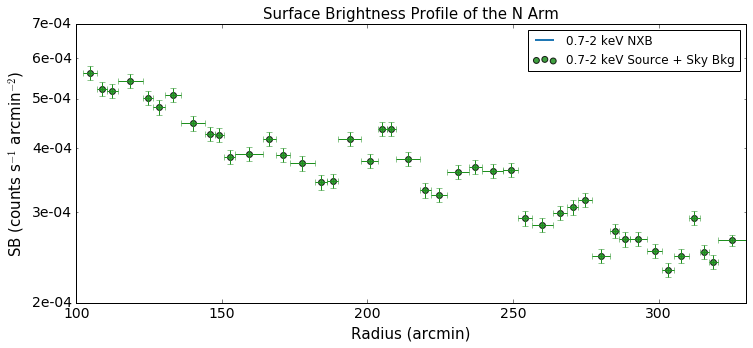

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.dpi = 300
fig.set_size_inches(12, 5)

ax.scatter(r, sx, c="#1e8f1e", alpha=0.85, s=35, marker="o",
           label="0.7-2 keV Source + Sky Bkg")
ax.errorbar(r, sx, xerr=r_err, yerr=sx_err, linestyle="None", color="#1e8f1e")
ax.step(r, bkg, where="mid", color="#1f77b4", linewidth=2,
        label="0.7-2 keV NXB")
ax.step(r, bkg - bkg_err, where="mid", color="#1f77b4", linewidth=2, alpha=0.5, linestyle="--")
ax.step(r, bkg + bkg_err, where="mid", color="#1f77b4", linewidth=2, alpha=0.5, linestyle="--")

ax.semilogy()
ax.get_xaxis().set_major_formatter(mtick.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(mtick.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mtick.LogFormatterMathtext())
ax.get_yaxis().set_minor_formatter(mtick.FormatStrFormatter("%.0e"))
plt.tick_params(axis="both", which="major", labelsize=14)
plt.tick_params(axis="both", which="minor", labelsize=14)
plt.xlim(rmin, rmax)
plt.ylim(2e-4, 7e-4)
plt.xlabel("Radius (arcmin)", size=15)
plt.ylabel(r"SB (counts s$^{-1}$ arcmin$^{-2}$)", size=15)
plt.legend(loc=1)
plt.title("Surface Brightness Profile of the N Arm", size=15)
plt.show()

Model: Const1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude    
    -----------------
    0.000257148712158



FIT SUMMARY:

| Parameter   |     Value |   Lower Uncertainty |   Upper Uncertainty |
|-------------+-----------+---------------------+---------------------|
| amplitude   | 2.572e-04 |          -1.710e-06 |           1.717e-06 |





//anaconda/lib/python3.5/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method nelder-mead does not use gradient information (jac).
  RuntimeWarning)
/Users/gogrean/code/pyxel/pyxel/optimizers.py:97: OptimizeWarning: Unknown solver options: eps, factr
  args=fargs, tol=acc, **kwargs)


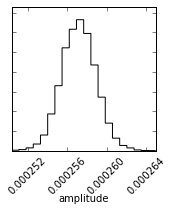

In [67]:
rmin_bkg = 275.
rmax_bkg = 330.

r = np.array([pp[0] for pp in p if rmin_bkg <= pp[0] <= rmax_bkg])
r_err = np.array([pp[1] for pp in p if rmin_bkg <= pp[0] <= rmax_bkg])
raw_cts = np.array([pp[2] for pp in p if rmin_bkg <= pp[0] <= rmax_bkg])
bkg_cts = np.array([pp[4] for pp in p if rmin_bkg <= pp[0] <= rmax_bkg])
t_raw = np.array([pp[11] for pp in p if rmin_bkg <= pp[0] <= rmax_bkg]) / norm_factor
t_bkg = np.array([pp[12] for pp in p if rmin_bkg <= pp[0] <= rmax_bkg]) / norm_factor

model = Const1D(amplitude=2.6e-4)
fit = CstatFitter()
fitted_model = fit(model, r, raw_cts, bkg_cts, t_raw, t_bkg, maxiter=500)
print(fitted_model)

mcmc_err = fit.mcmc_err(fitted_model, r, raw_cts, bkg_cts, t_raw, t_bkg, 
                        cl=68.269, save_chain=True, clobber_chain=False, 
                        chain_filename=DATADIR+"N_arm_skybkg_chain.dat")

Model: CompoundModel8
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <PowerLaw1D(amplitude=0.0006, x_0=100.0, alpha=1.0)>

    [1]: <Const1D(amplitude=0.0002572)>
Parameters:
       amplitude_0    x_0_0    alpha_0    amplitude_1
    ----------------- ----- ------------- -----------
    0.000383265607301 100.0 2.14769131678   0.0002572 



//anaconda/lib/python3.5/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method nelder-mead does not use gradient information (jac).
  RuntimeWarning)
/Users/gogrean/code/pyxel/pyxel/optimizers.py:97: OptimizeWarning: Unknown solver options: eps, factr
  args=fargs, tol=acc, **kwargs)





FIT SUMMARY:

| Parameter   |     Value |   Lower Uncertainty |   Upper Uncertainty |
|-------------+-----------+---------------------+---------------------|
| amplitude_0 | 3.834e-04 |          -6.719e-06 |           7.073e-06 |
| alpha_0     | 2.148e+00 |          -3.367e-02 |           3.479e-02 |





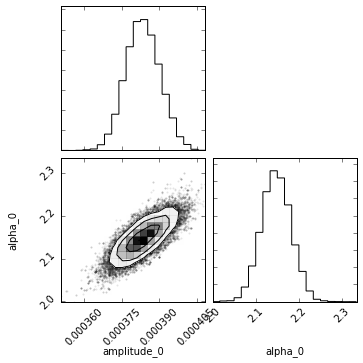

In [72]:
model = PowerLaw1D(amplitude=6e-4, x_0=100., alpha=1.) + Const1D(amplitude=2.572e-4)
model.x_0_0.fixed = True
model.amplitude_1.fixed = True

fit = CstatFitter()
fitted_model = fit(model, r, raw_cts, bkg_cts, t_raw, t_bkg, maxiter=1000)
print(fitted_model, '\n')

mcmc_err = fit.mcmc_err(fitted_model, r, raw_cts, bkg_cts, t_raw, t_bkg, 
                        cl=68.269, save_chain=True, clobber_chain=False, 
                        chain_filename=DATADIR+"N_arm_powerlaw_chain.dat")

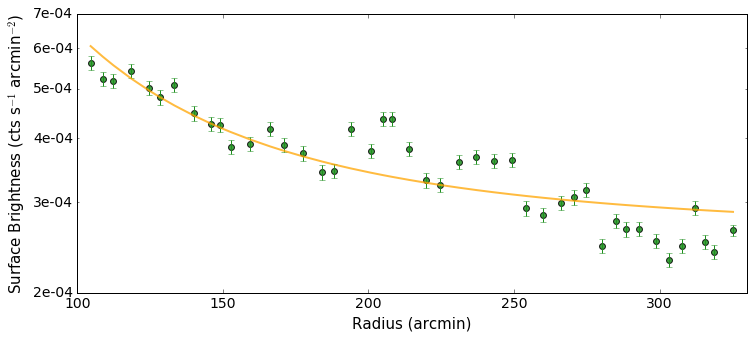

In [74]:
fig, ax = plt.subplots(figsize=(12, 5))

plt.scatter(r, sx, c="#1e8f1e", alpha=0.85, s=35, marker="o",
           label="0.7-2 keV Source + Sky Bkg")
plt.errorbar(r, sx, yerr=sx_err, linestyle="None", c="#1e8f1e")
plt.plot(r, fitted_model(r), color="#ffa500", linewidth=2, alpha=0.75)

plt.xlim(rmin, rmax)
plt.ylim(2e-4, 7e-4)
plt.semilogy()

plt.xlabel('Radius (arcmin)', size=15)
plt.ylabel(r"Surface Brightness (cts s$^{-1}$ arcmin$^{-2}$)", size=15)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=14)

ax.get_xaxis().set_major_formatter(mtick.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(mtick.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mtick.LogFormatterMathtext())
ax.get_yaxis().set_minor_formatter(mtick.FormatStrFormatter("%.0e"))